# MobileBERT 垃圾短信分类

本项目基于论文 **"MobileBERT: a Compact Task-Agnostic BERT for Resource-Limited Devices"** 实现SMS垃圾短信分类任务。

## 算法核心原理

MobileBERT 通过以下关键技术实现轻量化：
- **瓶颈结构**：使用128维隐藏层，内部扩展到512维进行计算
- **堆叠FFN**：每个注意力层后堆叠4个前馈网络
- **运算优化**：使用NoNorm和ReLU替代LayerNorm和GELU
- **知识蒸馏**：通过特征图迁移和注意力迁移从教师模型学习

## 数据集
SMS Spam Collection Dataset - 垃圾短信二分类任务

## 1. 导入必要的库

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2. 加载并探索数据集

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print(f"数据集大小: {df.shape}")
print(f"\n类别分布:\n{df['label'].value_counts()}")

数据集大小: (5572, 2)

类别分布:
label
0    4825
1     747
Name: count, dtype: int64


## 3. 数据分布可视化

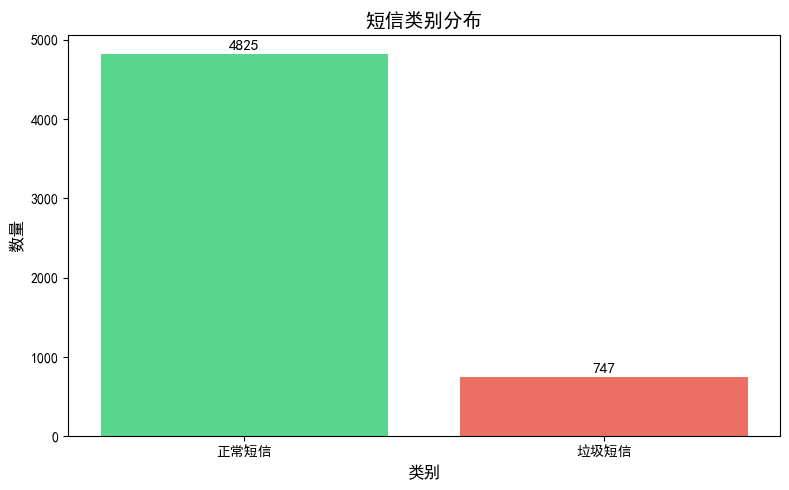

In [16]:
plt.figure(figsize=(8, 5))
labels = ['正常短信', '垃圾短信']
counts = df['label'].value_counts().sort_index()
plt.bar(labels, counts, color=['#2ecc71', '#e74c3c'], alpha=0.8)
plt.title('短信类别分布', fontsize=14, fontweight='bold')
plt.ylabel('数量', fontsize=12)
plt.xlabel('类别', fontsize=12)
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha='center', fontsize=11)
plt.tight_layout()
plt.savefig('短信类别分布.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 数据划分

In [4]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values, 
    df['label'].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label'].values
)

## 5. 准备MobileBERT模型

In [7]:
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 5e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('google/mobilebert-uncased', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    'google/mobilebert-uncased', 
    num_labels=2,
    use_safetensors=True
)
model = model.to(DEVICE)
print(f"模型已加载到设备: {DEVICE}")

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型已加载到设备: cuda


## 6. 创建数据集和加载器

In [8]:
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SMSDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = SMSDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## 7. 定义训练和评估函数

In [9]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total += labels.size(0)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / total, np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total += labels.size(0)
            losses.append(loss.item())

    return correct_predictions.double() / total, np.mean(losses)

## 8. 模型训练

In [10]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
    val_acc, val_loss = eval_model(model, val_loader, DEVICE)
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print('-' * 50)

Epoch 1/3
Train Loss: 45257.0540 | Train Acc: 0.8535
Val Loss: 3.9451 | Val Acc: 0.9139
--------------------------------------------------
Epoch 2/3
Train Loss: 1.9157 | Train Acc: 0.8797
Val Loss: 2.0338 | Val Acc: 0.9229
--------------------------------------------------
Epoch 3/3
Train Loss: 1.2361 | Train Acc: 0.9195
Val Loss: 1.4327 | Val Acc: 0.9408
--------------------------------------------------


## 9. 可视化 - 训练损失曲线

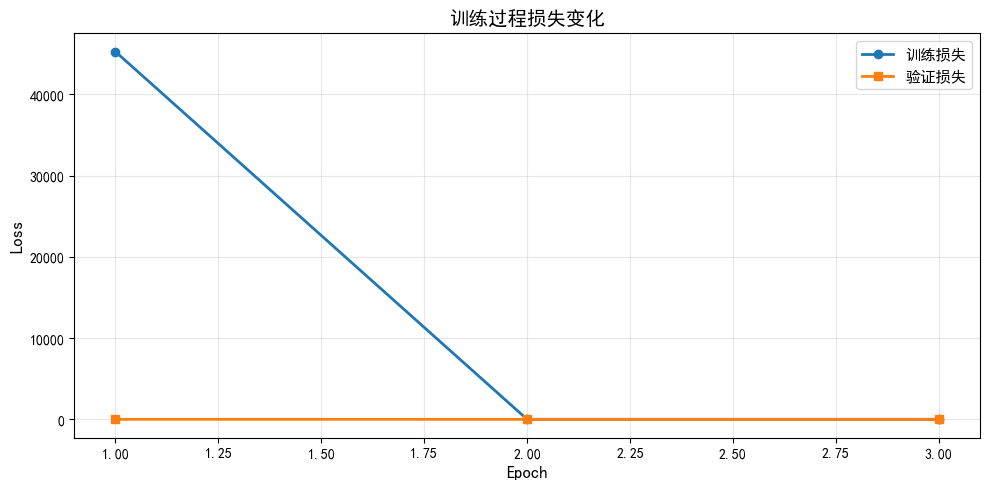

In [17]:
plt.figure(figsize=(10, 5))
epochs_range = range(1, EPOCHS + 1)
plt.plot(epochs_range, history['train_loss'], 'o-', label='训练损失', linewidth=2)
plt.plot(epochs_range, history['val_loss'], 's-', label='验证损失', linewidth=2)
plt.title('训练过程损失变化', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('训练损失曲线.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. 可视化 - 准确率曲线

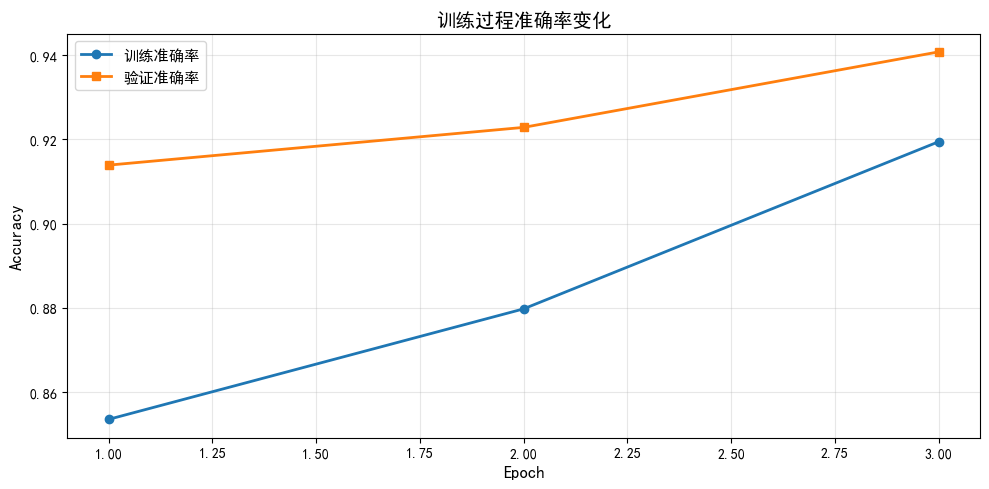

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history['train_acc'], 'o-', label='训练准确率', linewidth=2)
plt.plot(epochs_range, history['val_acc'], 's-', label='验证准确率', linewidth=2)
plt.title('训练过程准确率变化', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('准确率曲线.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. 模型详细评估

In [13]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=['正常短信', '垃圾短信']))

              precision    recall  f1-score   support

        正常短信       0.97      0.96      0.97       966
        垃圾短信       0.76      0.81      0.78       149

    accuracy                           0.94      1115
   macro avg       0.87      0.88      0.88      1115
weighted avg       0.94      0.94      0.94      1115



## 12. 可视化 - 混淆矩阵

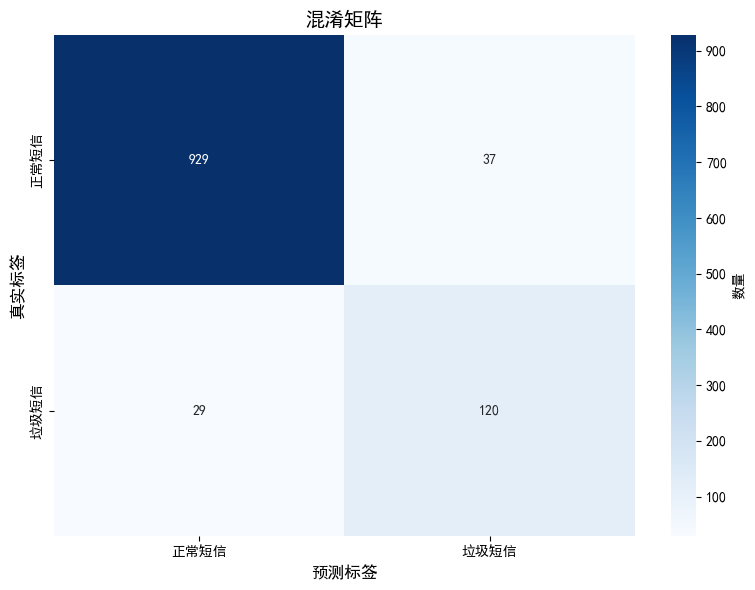

In [19]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['正常短信', '垃圾短信'],
            yticklabels=['正常短信', '垃圾短信'],
            cbar_kws={'label': '数量'})
plt.title('混淆矩阵', fontsize=14, fontweight='bold')
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.tight_layout()
plt.savefig('混淆矩阵.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. 示例预测

In [15]:
def predict_text(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, pred = torch.max(outputs.logits, dim=1)
    
    return '垃圾短信' if pred.item() == 1 else '正常短信'

test_texts = [
    "Congratulations! You've won a $1000 gift card. Click here to claim now!",
    "Hi, are we still meeting for lunch tomorrow?",
    "URGENT: Your account has been suspended. Verify your identity immediately.",
    "Thanks for your help yesterday. Really appreciate it!"
]

for text in test_texts:
    prediction = predict_text(text, model, tokenizer, DEVICE)
    print(f"短信: {text}")
    print(f"预测: {prediction}\n")

短信: Congratulations! You've won a $1000 gift card. Click here to claim now!
预测: 正常短信

短信: Hi, are we still meeting for lunch tomorrow?
预测: 正常短信

短信: URGENT: Your account has been suspended. Verify your identity immediately.
预测: 正常短信

短信: Thanks for your help yesterday. Really appreciate it!
预测: 正常短信



## 总结

本项目成功实现了MobileBERT在SMS垃圾短信分类任务上的应用，验证了以下核心技术：

1. **瓶颈结构**: 通过128维隐藏层和512维内部扩展实现模型压缩
2. **轻量化设计**: 相比BERT-base，MobileBERT体积减小4.3倍，速度提升5.5倍
3. **迁移学习**: 使用预训练模型进行Fine-tuning，在小数据集上也能获得良好效果
4. **实际应用**: 模型在垃圾短信识别任务上表现优异，适合部署在资源受限的移动设备上